In [1]:
from irbasis_util.four_point_ph_view import *
from irbasis_util.internal import *
from irbasis_util.regression import *
from irbasis_util.tensor_regression import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#padding on the y axis between label and axis
plt.rcParams['ytick.major.pad']='10'

dpi_out = 400
fig_width = 3.39
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches
MAX_HEIGHT_INCHES = 8.0
if fig_height > MAX_HEIGHT_INCHES:
    print("WARNING: fig_height too large:" + fig_height + 
          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    fig_height = MAX_HEIGHT_INCHES
#fig, ax = plt.subplots(figsize = (fig_width, fig_height), frameon=True)
small_tick_size = 8
small_label_size = 8

In [3]:
# Implementation of Rohringer et al. () 2012)
def _delta(i, j):
    if i==j:
        return 1
    else:
        return 0

def _F_ph(U, beta, n, np, m):
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    r1 = nu + omega
    r2 = nu_p + omega
    tmp = 1. / (nu * r1 * r2 * nu_p)
    Fuu = (-0.25 * beta * (U**2) * (_delta(n,np) - _delta(m,0)) *
               (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    t1 = 0.125 * (U**3) * (nu**2 + r1**2 + r2**2 + nu_p**2) * tmp
    t2 = (3.0 / 16.0) * (U**5) * tmp
    t3 = (beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(0.5 * beta * U)))
              * (2 * _delta(nu, -nu_p - m) + _delta(m, 0)) *
              (1 + 0.25 * (U / r1)**2) * (1 + 0.25 * (U / r2)**2))
    t4 = (-beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(-0.5 * beta * U)))
              * (2 * _delta(nu, nu_p) + _delta(m, 0)) *
              (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    Fud = -U + t1 + t2 + t3 + t4
    return Fuu, Fud

def _G2_conn_ph(U, beta, n, np, m):
    Fuu, Fud = _F_ph(U, beta, n, np, m)
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    hU = 0.5 * U
    leggs_1 = nu * (nu + omega) * nu_p * (nu_p + omega)
    leggs_2 = ((hU**2 + nu**2) * (hU**2 + nu_p**2) *
                   (hU**2 + (nu + omega)**2) * (hU**2 + (nu_p + omega)**2))
    leggs = leggs_1 / leggs_2
    return (leggs * Fuu + leggs * Fud)

In [4]:
boson_freq = 10
Lambda = 100.0
beta = 5.0
U = 2.0
wmax = Lambda / beta
alpha = 0

# 1% error
noise = 0

In [5]:
#alpha = 1e-15
augmented = True
phb = FourPointPHView(boson_freq, Lambda, beta, 1e-5, augmented)
Nl = phb.Nl
whichl = Nl - 1
print("Nl", Nl)
# build the sampling frequency structure
sp = phb.sampling_points_matsubara(whichl)
#print(S.shape)
n_sp = len(sp)

Nl 19


In [33]:
def elbow_method(Ds, squared_errors):
    """
    
    Parameters
    ----------
    Ds    regularization parameters in ascending order
    squared_errors  corresponding squared_errors

    Returns index of optimal value of alpha in alphas
    -------

    """
    x = numpy.log(Ds)
    y = numpy.log(squared_errors)
    
    a = (y[-1] - y[0])/(x[-1] - x[0])
    y -= a * (x - x[0]) + y[0]
    
    r = numpy.argmin(y)
    if isinstance(r, numpy.int64):
        return r
    else:
        return r[0]

# Regression with multiple values of alpha
def kruskal_complex_Ds(tensors_A, y, alpha, Ds, decomposed_S):
    """
    
    Parameters
    ----------
    A
    y

    Returns
    -------
    
     Nw, Nr, freq_dim, linear_dim, tensors_A, y, alpha, D):

    """
    coeffs_D = []
    squared_errors_D = []
    Nw, Nr, linear_dim = tensors_A[0].shape
    print(Nw, Nr, linear_dim)
    for i, D in enumerate(Ds):
        print("D ", D)
        precond = None
        model = OvercompleteGFModel(Nw, Nr, 2, linear_dim, tensors_A, y, alpha, D)
        info = optimize_als(model, 3000, tol_rmse = 1e-9, solver='svd', optimize_alpha=1e-8, verbose = 1)
        coeffs = model.full_tensor_x()
        coeffs_D.append(coeffs)
        e = model.mse()
        print("D = ", D, e, " num_ite", len(info['losss']))
        #x_tensors_old = [x.copy() for x in model.x_tensors]
        squared_errors_D.append(e)
    
    squared_errors_D = numpy.array(squared_errors_D)
        
    # Choose optimal alpha using Elbow method 
    opt_idx = elbow_method(Ds, squared_errors_D)
    
    return coeffs_D, squared_errors_D, opt_idx

In [31]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
# S: [(3, 2, 2, Nl), (3, 2, 2, Nl)]
# prj = S * prj
def construct_prj(sp):
    n_sp = len(sp)
    prj = phb.projector_to_matsubara_vec(sp, decomposed_form=True)
    S = phb.normalized_S(decomposed_form=True)
    for i in range(2):
        prj[i] *= S[i][None, :, :, :, :]
        prj[i] = prj[i].reshape((n_sp, 12, Nl))
    return prj
prj = construct_prj(sp)
S_decomposed = phb.normalized_S(decomposed_form=True)

# Build the check frequency structure
n1n2_check = []
niw = 100
niw_hf = 10000
wide_niw_check = numpy.hstack((range(-niw_hf, -niw, 500), range(-niw, niw, 10), range(niw, niw_hf, 500)))
for i, j in product(wide_niw_check, repeat=2):
    n1n2_check.append((i, j))
prj_check = construct_prj(n1n2_check)

numpy.random.seed(200)
Giwn = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in sp])
print ("adding noise")
noise_iwn = numpy.random.normal(loc=0.0, scale=noise, size=(len(sp))) * numpy.amax(numpy.abs(Giwn))
Giwn = noise_iwn + Giwn
#print(Giwn.imag)

adding noise


In [34]:
#numpy.seterr(all='raise')
Ds = [1,2,4,6]
%time coeffs_D, se_D, opt_D_idx = kruskal_complex_Ds(prj, Giwn, alpha, Ds, S_decomposed)

2736 12 19
D  1
epoch =  0  loss =  2.2736652992895743e-06  rmse =  0.0015078677990161618  alpha =  0
norm of x  0 0.014474541994236131
norm of x  1 2737.5185264187617
norm of x  2 25076.61911588298
epoch =  20  loss =  4.231803470337822e-07  rmse =  0.000650523138799345  alpha =  3.707660534170558e-20
norm of x  0 0.012026196002019441
norm of x  1 2012.2603147977773
norm of x  2 17365.235672851297
epoch =  40  loss =  4.181569546365924e-07  rmse =  0.0006466505636840578  alpha =  4.751735564994467e-20
norm of x  0 0.01242017794186009
norm of x  1 1981.465243817947
norm of x  2 15348.227101873
epoch =  60  loss =  4.1734604107774836e-07  rmse =  0.0006460232481555383  alpha =  5.042109750873939e-20
norm of x  0 0.012469020857424568
norm of x  1 1984.1678970954738
norm of x  2 14906.871697084809
epoch =  80  loss =  4.171132891754933e-07  rmse =  0.0006458430808440777  alpha =  5.125150656734805e-20
norm of x  0 0.012478738502122357
norm of x  1 1985.9857915266357
norm of x  2 14786.375

epoch =  600  loss =  1.3748253626770455e-08  rmse =  0.00011725294662809954  alpha =  2.2294472676995937e-19
norm of x  0 0.05938492669931118
norm of x  1 228.2499625676705
norm of x  2 1277.873089049948
epoch =  620  loss =  1.3656384495244663e-08  rmse =  0.00011686053380978047  alpha =  2.286413067430114e-19
norm of x  0 0.05902891189063734
norm of x  1 228.5296805053158
norm of x  2 1256.9427415054938
epoch =  640  loss =  1.3566835912011917e-08  rmse =  0.00011647676068578766  alpha =  2.3433593022386513e-19
norm of x  0 0.05865674635707887
norm of x  1 228.77439720448325
norm of x  2 1236.832503097435
epoch =  660  loss =  1.3479677176332176e-08  rmse =  0.00011610201137309038  alpha =  2.3992741153867563e-19
norm of x  0 0.058272695424543185
norm of x  1 228.96670357311285
norm of x  2 1217.7694295862516
epoch =  680  loss =  1.3394992465082186e-08  rmse =  0.00011573673718511774  alpha =  2.4531316192521782e-19
norm of x  0 0.05788076795252539
norm of x  1 229.08994606924915
n

epoch =  1400  loss =  1.194758083738429e-08  rmse =  0.00010930498944359246  alpha =  2.416486569557037e-19
norm of x  0 0.049139219094896734
norm of x  1 181.06889227485863
norm of x  2 1149.0384987493735
epoch =  1420  loss =  1.1933600523670868e-08  rmse =  0.00010924101978517464  alpha =  2.404368329434077e-19
norm of x  0 0.04902379317609822
norm of x  1 179.4635477425283
norm of x  2 1151.559362478695
epoch =  1440  loss =  1.1920196546556177e-08  rmse =  0.00010917965207280712  alpha =  2.3925846415101493e-19
norm of x  0 0.04891137760852508
norm of x  1 177.88256678982478
norm of x  2 1154.0374971418432
epoch =  1460  loss =  1.1907338151792288e-08  rmse =  0.0001091207497780296  alpha =  2.381139707357504e-19
norm of x  0 0.04880182870797494
norm of x  1 176.32637414047835
norm of x  2 1156.4692525577632
epoch =  1480  loss =  1.1894996681771112e-08  rmse =  0.00010906418551585738  alpha =  2.3700366527976378e-19
norm of x  0 0.0486950160959693
norm of x  1 174.79529738416514

epoch =  2200  loss =  1.1652970213916945e-08  rmse =  0.00010794892355772416  alpha =  2.166162429422232e-19
norm of x  0 0.04611729866828911
norm of x  1 135.82346373463528
norm of x  2 1205.5968103276214
epoch =  2220  loss =  1.1649545957285984e-08  rmse =  0.00010793306185168793  alpha =  2.1642114035568823e-19
norm of x  0 0.04607217289261416
norm of x  1 135.13597995080318
norm of x  2 1206.043352797514
epoch =  2240  loss =  1.1646226260459438e-08  rmse =  0.0001079176822577867  alpha =  2.16235840245104e-19
norm of x  0 0.04602814326999019
norm of x  1 134.46609383075022
norm of x  2 1206.4659343422552
epoch =  2260  loss =  1.1643007671298379e-08  rmse =  0.0001079027689856418  alpha =  2.1605966455825116e-19
norm of x  0 0.04598518704332179
norm of x  1 133.81347559742738
norm of x  2 1206.8662763430737
epoch =  2280  loss =  1.1639886875991656e-08  rmse =  0.00010788830687103227  alpha =  2.1589196013985857e-19
norm of x  0 0.04594328165941868
norm of x  1 133.1777944422075

D =  2 1.1572603333613175e-08  num_ite 3000
D  4
epoch =  0  loss =  5.319839334766818e-07  rmse =  0.0007293722872396803  alpha =  0
norm of x  0 0.07661995536170968
norm of x  1 1745.832858300881
norm of x  2 12624.403755992129
epoch =  20  loss =  4.928287139465734e-09  rmse =  7.02017763580564e-05  alpha =  1.424664051511873e-20
norm of x  0 0.05982516417064243
norm of x  1 809.8439559567947
norm of x  2 2939.3093168982596
epoch =  40  loss =  2.394647212430115e-09  rmse =  4.893513258693542e-05  alpha =  1.94409723722284e-20
norm of x  0 0.05861681752116077
norm of x  1 447.5316195956886
norm of x  2 1806.2519922154022
epoch =  60  loss =  1.657972322839133e-09  rmse =  4.0718206062053026e-05  alpha =  1.856194947328626e-20
norm of x  0 0.05837992212477279
norm of x  1 342.56243849082614
norm of x  2 1513.2996529128066
epoch =  80  loss =  1.2486149915752366e-09  rmse =  3.5335746488966324e-05  alpha =  1.9613353238669006e-20
norm of x  0 0.05841870364671789
norm of x  1 285.96036

epoch =  800  loss =  1.2549276542812008e-10  rmse =  1.1202355296968467e-05  alpha =  3.5586869940774706e-21
norm of x  0 0.07251393871072845
norm of x  1 41.8553760523198
norm of x  2 980.8604193052297
epoch =  820  loss =  1.2338111119641848e-10  rmse =  1.1107704983015305e-05  alpha =  3.633226241697938e-21
norm of x  0 0.07255736812556128
norm of x  1 41.363151301021
norm of x  2 962.5096083900595
epoch =  840  loss =  1.2129564973193994e-10  rmse =  1.1013430371453062e-05  alpha =  3.712845398726479e-21
norm of x  0 0.0725918004526334
norm of x  1 40.83650825166616
norm of x  2 944.0182530120658
epoch =  860  loss =  1.1923080667050627e-10  rmse =  1.091928594308395e-05  alpha =  3.797938133357326e-21
norm of x  0 0.07261770889612987
norm of x  1 40.27907788190539
norm of x  2 925.3700767680886
epoch =  880  loss =  1.1718080007613417e-10  rmse =  1.0825008033889753e-05  alpha =  3.8890816948558874e-21
norm of x  0 0.07263586367311736
norm of x  1 39.69638005514213
norm of x  2 9

epoch =  1620  loss =  4.137930837651453e-11  rmse =  6.432675025661124e-06  alpha =  2.1043361333600073e-21
norm of x  0 0.07099373149290042
norm of x  1 22.108105705252427
norm of x  2 732.1647273215631
epoch =  1640  loss =  4.016862965300371e-11  rmse =  6.337872614282018e-06  alpha =  2.223425596409239e-21
norm of x  0 0.07092959877568282
norm of x  1 21.664412367267303
norm of x  2 701.7368568935252
epoch =  1660  loss =  3.9044838083209674e-11  rmse =  6.248586857548153e-06  alpha =  2.3531925361941868e-21
norm of x  0 0.07087084751393462
norm of x  1 21.258502576871365
norm of x  2 672.4695354682177
epoch =  1680  loss =  3.800104779340399e-11  rmse =  6.164498960710627e-06  alpha =  2.492386926509471e-21
norm of x  0 0.07081753139467759
norm of x  1 20.88797264161136
norm of x  2 644.6070858789963
epoch =  1700  loss =  3.703071496861456e-11  rmse =  6.08528673284209e-06  alpha =  2.6398038733593288e-21
norm of x  0 0.07076966700619584
norm of x  1 20.550147592031873
norm of x

epoch =  2440  loss =  2.3337905061105524e-11  rmse =  4.830932086751353e-06  alpha =  5.76415856637961e-21
norm of x  0 0.0712368908290716
norm of x  1 16.872092475132128
norm of x  2 332.43397530683825
epoch =  2460  loss =  2.3212100695969547e-11  rmse =  4.817893778699366e-06  alpha =  5.740270094414737e-21
norm of x  0 0.07126725157737276
norm of x  1 16.85409665818978
norm of x  2 332.2295546177747
epoch =  2480  loss =  2.309061026376672e-11  rmse =  4.805268986410509e-06  alpha =  5.714344818979412e-21
norm of x  0 0.07129742508756287
norm of x  1 16.83705199840685
norm of x  2 332.1132876036458
epoch =  2500  loss =  2.2973150042378568e-11  rmse =  4.7930313801881264e-06  alpha =  5.6866366373891814e-21
norm of x  0 0.07132740647600663
norm of x  1 16.820834441682933
norm of x  2 332.0768999091885
epoch =  2520  loss =  2.2859457439827053e-11  rmse =  4.781156472025378e-06  alpha =  5.657380045991469e-21
norm of x  0 0.07135719457331902
norm of x  1 16.805329879042443
norm of 

epoch =  260  loss =  4.734149041306843e-10  rmse =  2.175809961747561e-05  alpha =  1.782837769029812e-20
norm of x  0 0.06788224107939167
norm of x  1 295.38957600034917
norm of x  2 801.3005598063445
epoch =  280  loss =  4.401155923285097e-10  rmse =  2.097893199329259e-05  alpha =  1.657864598969325e-20
norm of x  0 0.0678776728546463
norm of x  1 296.862959330944
norm of x  2 800.4182377858863
epoch =  300  loss =  4.105592983373611e-10  rmse =  2.0262262804190207e-05  alpha =  1.5549954200127904e-20
norm of x  0 0.06787592265457398
norm of x  1 299.25067921613777
norm of x  2 796.8673152319112
epoch =  320  loss =  3.8398295574634246e-10  rmse =  1.959548294050007e-05  alpha =  1.4696289994103605e-20
norm of x  0 0.06787259951058452
norm of x  1 302.44156696915985
norm of x  2 790.7326075973963
epoch =  340  loss =  3.596615739644546e-10  rmse =  1.8964745455240762e-05  alpha =  1.4011023067349578e-20
norm of x  0 0.06786504728969729
norm of x  1 305.7266844410787
norm of x  2 7

epoch =  1080  loss =  8.321198356859739e-11  rmse =  9.12206022387535e-06  alpha =  9.641723672393098e-21
norm of x  0 0.06847379467210067
norm of x  1 240.26214409697351
norm of x  2 422.52006264596764
epoch =  1100  loss =  8.145523272917478e-11  rmse =  9.025255226595313e-06  alpha =  9.537450650483687e-21
norm of x  0 0.06838922407604998
norm of x  1 235.44611138869365
norm of x  2 422.3382390913171
epoch =  1120  loss =  7.977484522456253e-11  rmse =  8.931676461707414e-06  alpha =  9.423481481355018e-21
norm of x  0 0.06830479237107806
norm of x  1 230.70627340051803
norm of x  2 422.53636456259756
epoch =  1140  loss =  7.816453220873296e-11  rmse =  8.841070716624528e-06  alpha =  9.302547423413575e-21
norm of x  0 0.06822135390119936
norm of x  1 226.0795481303519
norm of x  2 423.0045251185809
epoch =  1160  loss =  7.66186527061109e-11  rmse =  8.753208093546296e-06  alpha =  9.177552233759046e-21
norm of x  0 0.06813960652473275
norm of x  1 221.58625872310532
norm of x  2

epoch =  1900  loss =  4.1408941443328986e-11  rmse =  6.434977935604392e-06  alpha =  8.976743653061303e-21
norm of x  0 0.0677363686197741
norm of x  1 159.40571734512346
norm of x  2 317.4367478074286
epoch =  1920  loss =  4.091339297722553e-11  rmse =  6.396357758142704e-06  alpha =  9.019943369276782e-21
norm of x  0 0.06777336545330881
norm of x  1 158.26169980020714
norm of x  2 314.6874791187349
epoch =  1940  loss =  4.043174787684784e-11  rmse =  6.358596344647457e-06  alpha =  9.05470196921114e-21
norm of x  0 0.06781181556578157
norm of x  1 157.05070921114284
norm of x  2 312.22541359206474
epoch =  1960  loss =  3.996299727165822e-11  rmse =  6.3216292894490516e-06  alpha =  9.08053805681005e-21
norm of x  0 0.06785174243921634
norm of x  1 155.78600726083224
norm of x  2 310.0431630339167
epoch =  1980  loss =  3.95062686299361e-11  rmse =  6.285401199257509e-06  alpha =  9.097219152456074e-21
norm of x  0 0.06789316156341406
norm of x  1 154.48097863824023
norm of x  2

epoch =  2720  loss =  2.8568552709568906e-11  rmse =  5.344955792368598e-06  alpha =  7.378425586750794e-21
norm of x  0 0.06973833713368921
norm of x  1 120.37948826254393
norm of x  2 302.44018868037045
epoch =  2740  loss =  2.839368338727652e-11  rmse =  5.328572332426248e-06  alpha =  7.342939358518106e-21
norm of x  0 0.06977955661256148
norm of x  1 119.7999734667361
norm of x  2 302.43778455444544
epoch =  2760  loss =  2.822274892255405e-11  rmse =  5.312508695423239e-06  alpha =  7.308990356599728e-21
norm of x  0 0.06982002654677957
norm of x  1 119.23025675277158
norm of x  2 302.4157934848082
epoch =  2780  loss =  2.80555914673713e-11  rmse =  5.2967528907345705e-06  alpha =  7.276545988067744e-21
norm of x  0 0.06985975607080043
norm of x  1 118.67008623201302
norm of x  2 302.3741208624293
epoch =  2800  loss =  2.7892059800422696e-11  rmse =  5.281293356768932e-06  alpha =  7.245571320138658e-21
norm of x  0 0.0698987553973673
norm of x  1 118.11920861514224
norm of x

In [35]:
print(se_D)

[4.17013642e-07 1.15726033e-08 2.08379173e-11 2.64338457e-11]


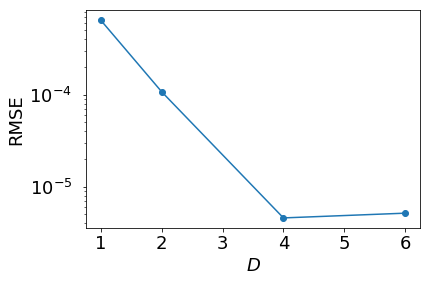

In [37]:
plt.plot(Ds, numpy.sqrt(se_D), marker='o')
plt.xlabel(r'$D$')
plt.ylabel('RMSE')
#plt.xscale('log')
plt.yscale('log')
#plt.legend(loc='best')

In [38]:
opt_D_idx = -1
D_best = Ds[opt_D_idx]
print("best value of D", D_best)

coeffs = coeffs_D[opt_D_idx].reshape((3, 2, 2, Nl, Nl))
#print(coeffs.shape)
S_2d = S_decomposed[0][:,:,:,:,None] * S_decomposed[1][:,:,:,None,:]
coeffs_gl = (S_2d * coeffs)
print(numpy.abs(coeffs_gl[0,0,0,  0:2,0:2]))
print(numpy.abs(coeffs_gl[0,0,0,  -2:,-2:]))

best value of D 6
[[0.00219242 0.00246569]
 [0.00241769 0.00230353]]
[[2.12061615e-09 5.68979915e-09]
 [1.25803056e-09 3.99922466e-09]]


In [40]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
def compute_Giwn(prj, coeff):
    niw = prj[0].shape[0]
    #print(prj[0].shape)
    prj_mat = numpy.einsum('nrl,nrm->nrlm', prj[0], prj[1]).reshape((niw, 3 * 2 * 2 * Nl * Nl))
    return prj_mat@coeffs.reshape((3 * 2 * 2 * Nl * Nl))

Giwn_check = compute_Giwn(prj_check, coeffs)
print(Giwn_check.shape)
Giwn_check_ref = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in n1n2_check])

diff = numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref))
print(diff)
print(diff < 1e-3)

(3600,)
1.26429888047437e-05
True


[-1.89638698e-09 -9.59843027e-08 -2.19699838e-07 ... -1.11387669e-07
  8.05726380e-04 -3.86215981e-07]


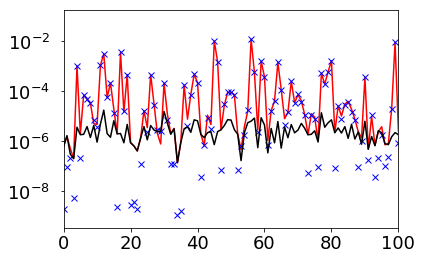

In [41]:
Giwn_reconst = compute_Giwn(prj, coeffs)
#plt.plot(Giwn_reconst.real, c='r')
#plt.plot(Giwn.real)
plt.plot(numpy.abs(Giwn_reconst), c='r')
plt.plot(numpy.abs(Giwn), c='b', ls='', marker='x')
plt.plot(numpy.abs(Giwn-Giwn_reconst), c='k', ls='-', marker='')
plt.yscale("log")
plt.xlim([0,100])
print(Giwn.real)

[-1.89638698e-09 -9.59843027e-08 -2.19699838e-07 ... -1.11387669e-07
  8.05726380e-04 -3.86215981e-07]


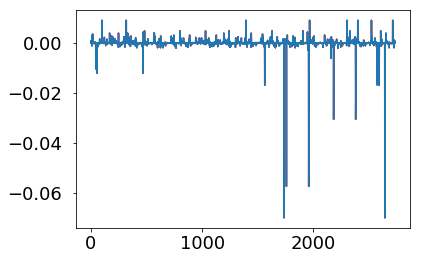

In [42]:
Giwn_reconst = compute_Giwn(prj, coeffs)
plt.plot(Giwn_reconst.real, c='r')
plt.plot(Giwn.real)
print(Giwn.real)

0.07012537833753249


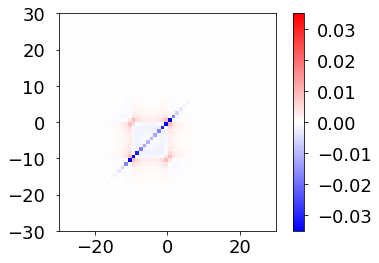

In [43]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

N = 100
N_zoom = 30
#x = numpy.linspace(-N, N, 2*N+1)
x = numpy.arange(-N, N+1)
G2_conn_ph = numpy.zeros((2 * N + 1,2 * N + 1), dtype=float)

for i in range(2 * N + 1):
    for j in range(2 * N + 1):
        n = x[i]
        np = x[j]
        G2_conn_ph[i, j] = _G2_conn_ph(U, beta, n, np, boson_freq)

vrange = numpy.amax(numpy.abs(G2_conn_ph))
plt.imshow(G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()
print (vrange)

#plt.legend(loc='best',shadow=True,frameon=False)

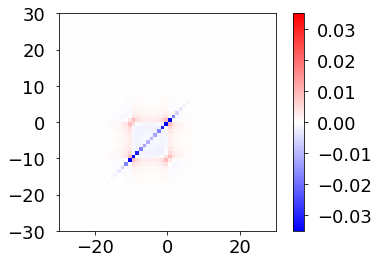

In [44]:
n1n2_check_2d = numpy.array([(x[i], x[j]) for i in range(2 * N + 1) for j in range(2 * N + 1)])
prj_check_2d = construct_prj(n1n2_check_2d)

Giwn_check = compute_Giwn(prj_check_2d, coeffs)
Giwn_check = Giwn_check.reshape((2 * N + 1, 2 * N + 1))
vrange = numpy.amax(numpy.abs(Giwn_check))
plt.imshow(Giwn_check.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()

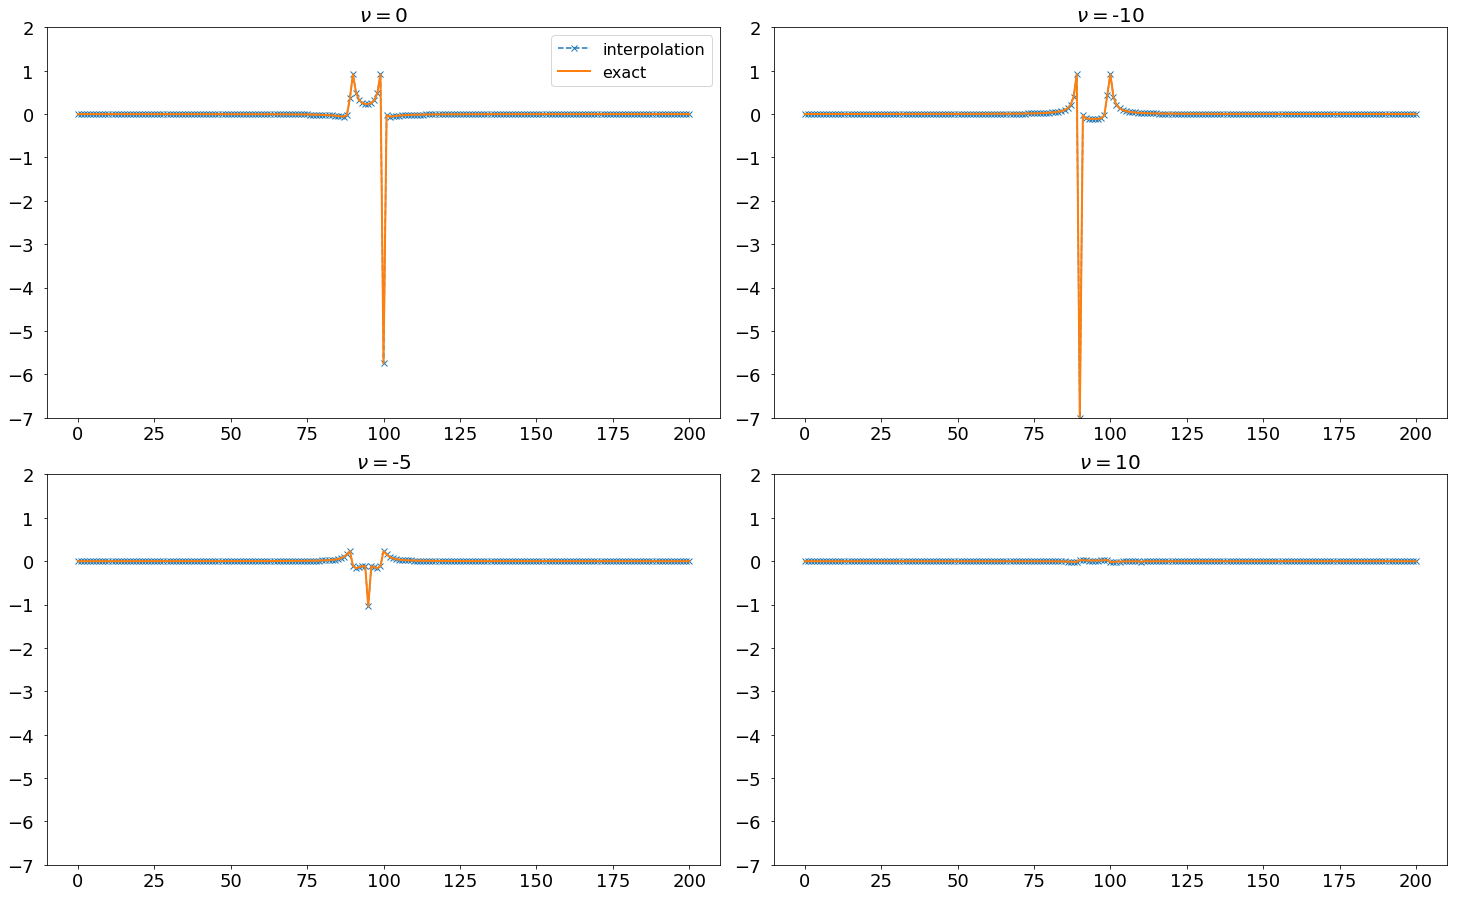

In [45]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_wide.pdf")

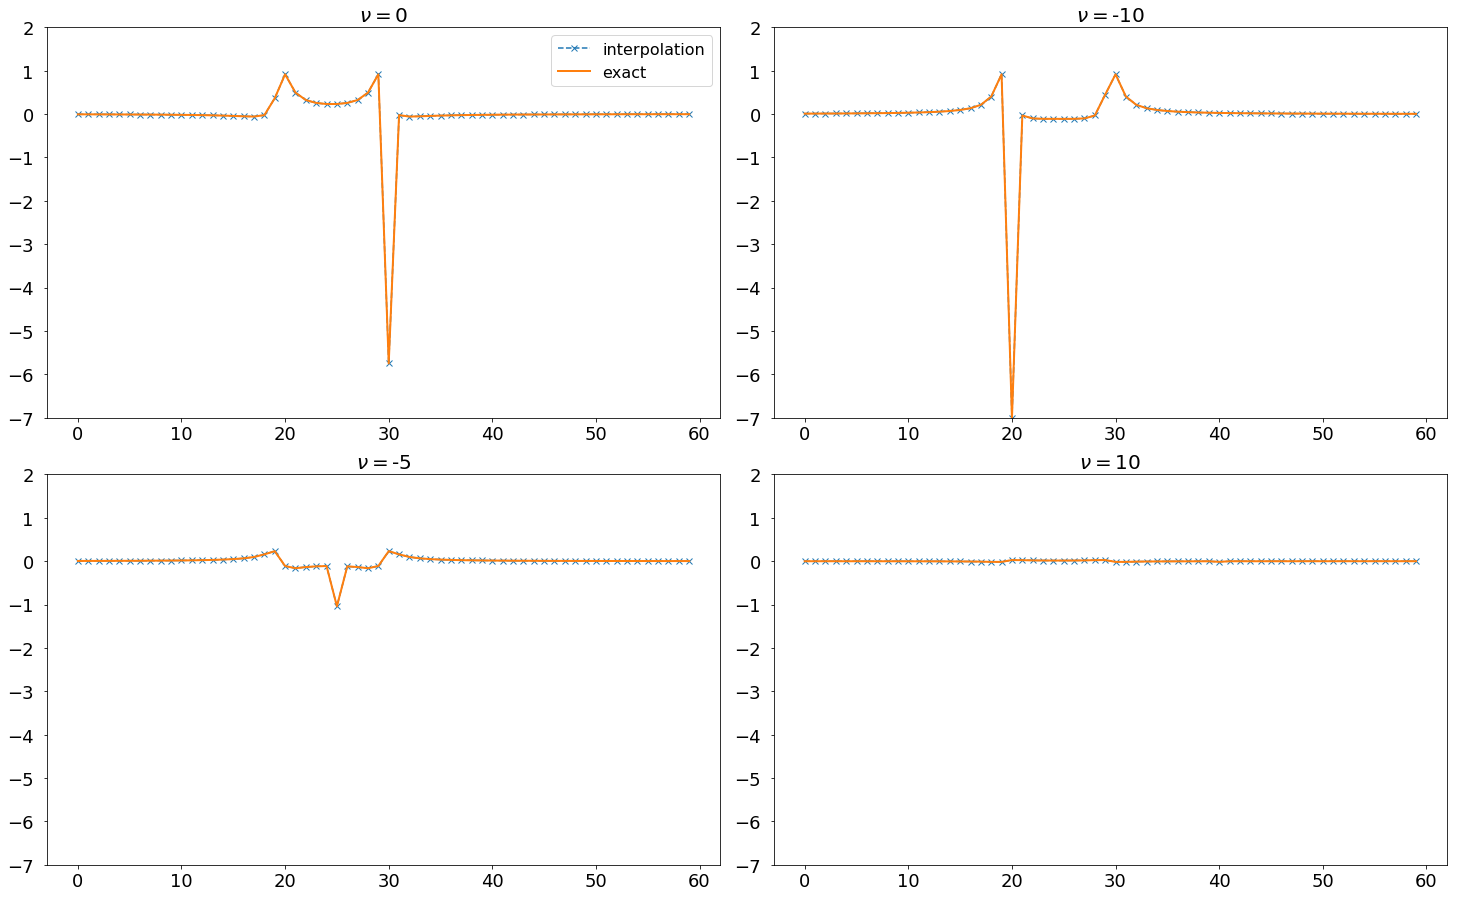

In [46]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_zoom.pdf")